# Single echelon systems
### ---- one warehouse, one customer

### The problem
This notebook involves determining the **reorder quantity** and the **reorder point** by minimizing the total cost under certain constraint of service level. 
1. total system costs = the cost of buying products from the suppliers
2. service level = # of back out orders / # of total orders 


#### Terminology
1. reorder quantity: the amount requested products in each replenishment order. (lot size)
2. Lead time: time gap between initiating a replenishment order and receiving the shipment. 
3. Reorder Point Policy (ROP):  An order is placed when the stock reaches a predetermined number of units, called the reorder point. In real life, Reorder Point is often checked in a pre-determined frequency.
4. Stock out: The inventory is completely exhausted and customer demand for the product connot be fulfilled
5. Backorder: demand orders that will be fulfilled later.
6. Service level: A metric to quantify the level of stockouts that can be tolerated in order to meet the desired level of customer satisfaction. 
7. Cycle clock: The inventory maintained to serve customers' orders received during the lead time

### The Supply chain assumption

The logic of the simulated supply chain is based on a real After-sales service supply chain, which means that the service level is the most basic and important metric.To make life easier, I reduced # of warehouse to 1. When considering more than 1 warehouse, the distance between warehouse and buyer have to be considered, and graph programming is needed. Aslo, data becomes extremely difficult to generated.

#### Supply chain structure:
The supply chain is combined by one warehouse and 6 types of products. The warehouse need to supply products to buyers, and checking the Reorder Point every week. When the Reorder Point is reached, the wearehouse will order products from suppliers. Aslo the # of products in the warehouse have to be fewer than the warehouse capacity.

1. demand: In this notebook, demands are generated by normal and gamma distribution. But in real world, they are predicted, and may show seasonality and linearity. If I get data in furture, I will use time series model and MCMC to generate more than 6000 demands.
 <table>
        <tr>
            <th>Product name</th>
            <th>demand</th>
            <th>Price</th>
            <th>Lead time</th>
            <th>Volume</th>
        </tr>
        <tr>
            <th>Product1</th>
            <th>Gamma(0.4,3)</th>
            <th>3200</th>
            <th>17</th>
            <th>18</th>
        </tr>
        <tr>
            <th>Product2</th>
            <th>Gamma(3,3)</th>
            <th>2400</th>
            <th>30</th>
            <th>25</th>
        </tr>
        <tr>
            <th>Product3</th>
            <th>Normal(7,0.5)</th>
            <th>1200</th>
            <th>6</th>
            <th>7</th>
        </tr>
        <tr>
            <th>Product4</th>
            <th>Normal(23,4)</th>
            <th>500</th>
            <th>8</th>
            <th>63</th>
        </tr>
        <tr>
            <th>Product5</th>
            <th>Normal(6,3)</th>
            <th>73</th>
            <th>14</th>
            <th>3</th>
        </tr>
        <tr>
            <th>Product6</th>
            <th>Normal(47,12)</th>
            <th>14</th>
            <th>3</th>
            <th>12</th>
        </tr>
    </table>

2. Replenishment happends before buyer's order
3. Reorder Point is checked every 7 days (1 week)
4. The warehouse capacity is fixed. When the total volume of products in the warehouse reaches the maximum capacity of warehouse, the products received from suppliers will be destroyed. When larger than 80%, half of them will be destroyed. 

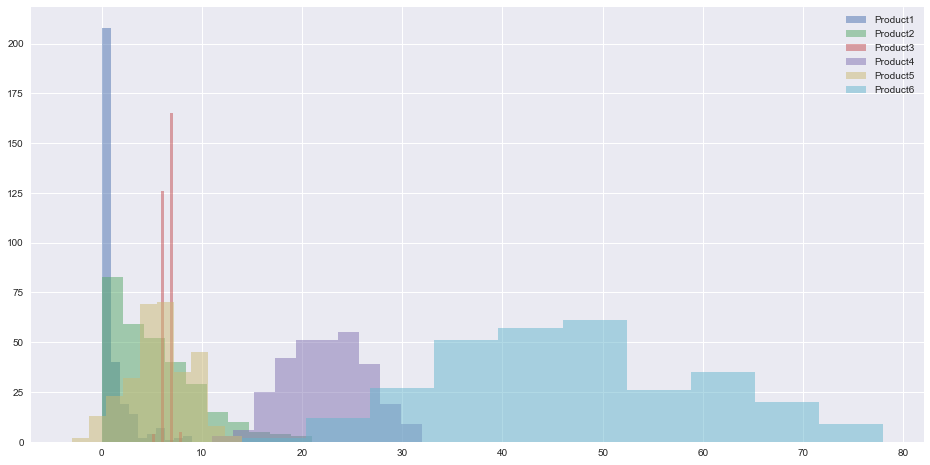

In [3]:
import simpy
from Warehouse import stockingFacility
from products import generate_products
import matplotlib.pyplot as plt
from objective_function import plot_warehouse
days = 300
productDict = generate_products(days, plotdata = True)
ROP = {"Product1": 30.0,
       "Product2": 100.0,
       "Product3": 300.0,
       "Product4": 550.0,
       "Product5": 250.0,
       "Product6": 700.0}
ROQ = {"Product1": 70.0,
       "Product2": 150.0,
       "Product3": 300.0,
       "Product4": 500.0,
       "Product5": 250.0,
       "Product6": 700.0}
initialInv = dict()
for product_name in ROP.keys():
    initialInv[product_name] = ROP[product_name] + ROQ[product_name]


env = simpy.Environment()
WarehouseA = stockingFacility(env, 
                              productDict = productDict,
                              initialInv = initialInv, 
                                ROP = ROP, 
                                ROQ = ROQ, 
                                warehouseCapacity = 100000,
                                warningCapPoint = 0.8,
                                stdLeadTime = 0.5)
env.run(until=days)

all cost is:  12558800.0


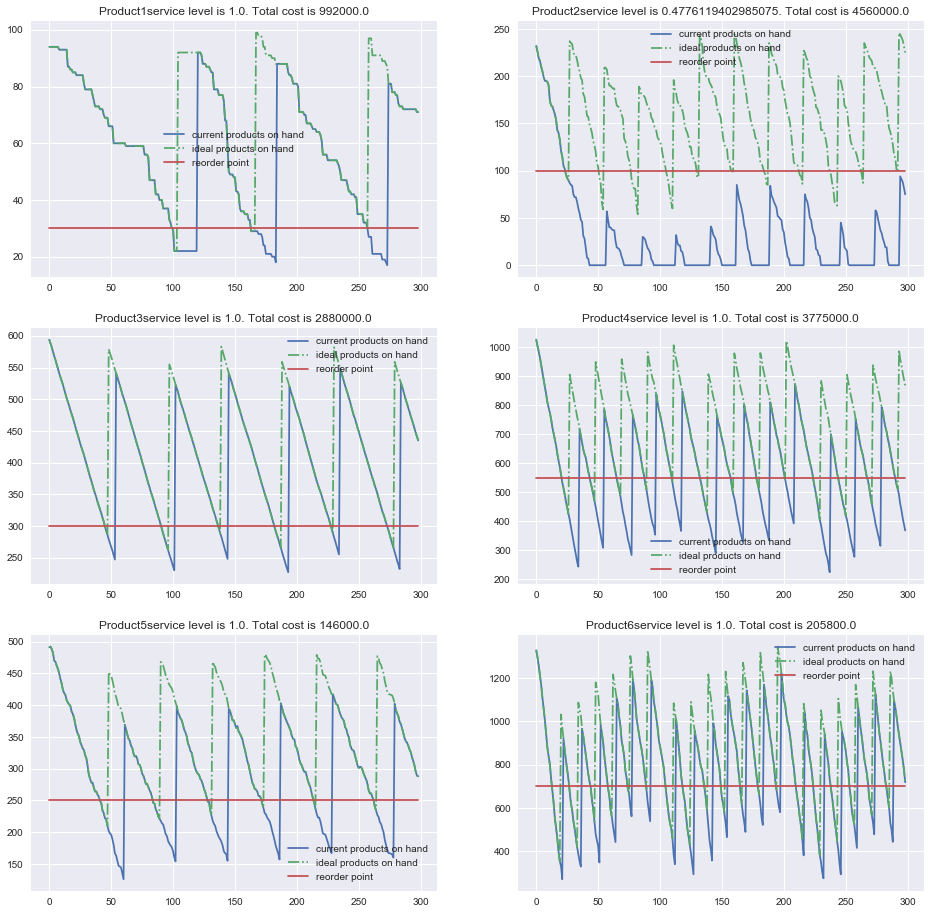

In [4]:
plot_warehouse(WarehouseA,days)

The picture abouve shows that there are trade if between total cost and service level. The gap between two adjacent green and blue line is the lead time. 

## Bayesian Optimization

In the simulation, There are actually two constraints. First is the warehouse capacity, second is the survice level. I make service level lower when dealing with warehouse capacity, but service level is not in the course of optimization, so warehouse is dead completely. 

There are two ways we can deal with service level:
1. We can add a large penality to the objective function when the service level is lower than demand,
<center> cost = sum((target service level - calculated service level) * total demand * penalty)

In [5]:
import numpy as np
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern,RBF
import matplotlib.pyplot as plt

from objective_function import objective_function_penalty,print_result
import numpy as np
def initial_points(bounds, nums):
    X_init = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(nums, bounds.shape[0]))
    Y_init = []
    for x in X_init:
        #print(x)
        Y_init.append(obj(x))
    return X_init, np.array(Y_init).reshape(-1, )

In [17]:
def obj(x):
    res = objective_function_penalty(x,penalty = 10000000, target_service_level = 0.8, days = 300, plotdata = False)
    return res
bounds = np.array([[20,800] for _ in range(12)])

In [18]:
X_init, Y_init= initial_points(bounds, 10)

In [19]:
min(Y_init)

27019546168.685265

In [20]:
# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1) * RBF(np.array([0.5]*12))
gpr = GaussianProcessRegressor(kernel=m52, alpha=10, noise = "gaussian")

r1 = gp_minimize(obj, 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=50,         # number of iterations
                n_random_starts=20,
                acq_optimizer ="sampling",
                # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=Y_init.ravel())

the minimize cost is, 12941996.0
the best parameter is [38, 220, 134, 771, 108, 443, 399, 65, 453, 170, 762, 678]
all cost is:  12785996


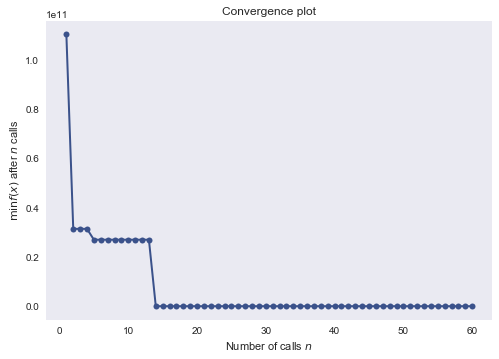

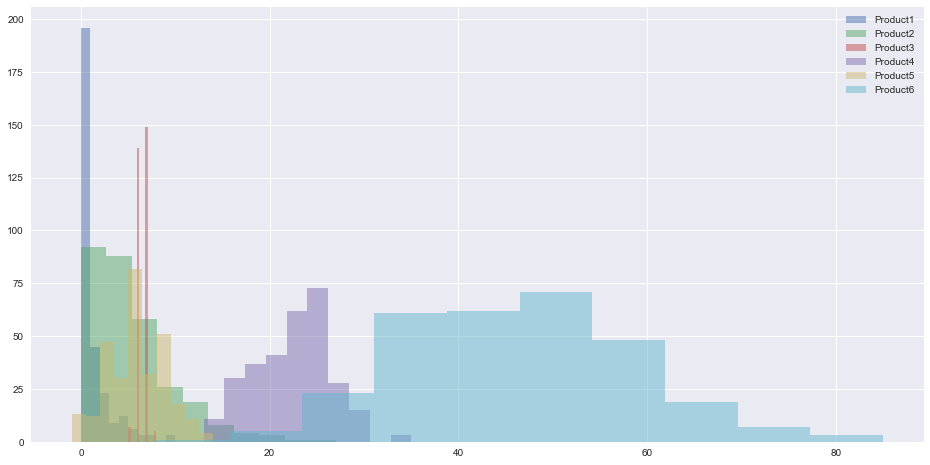

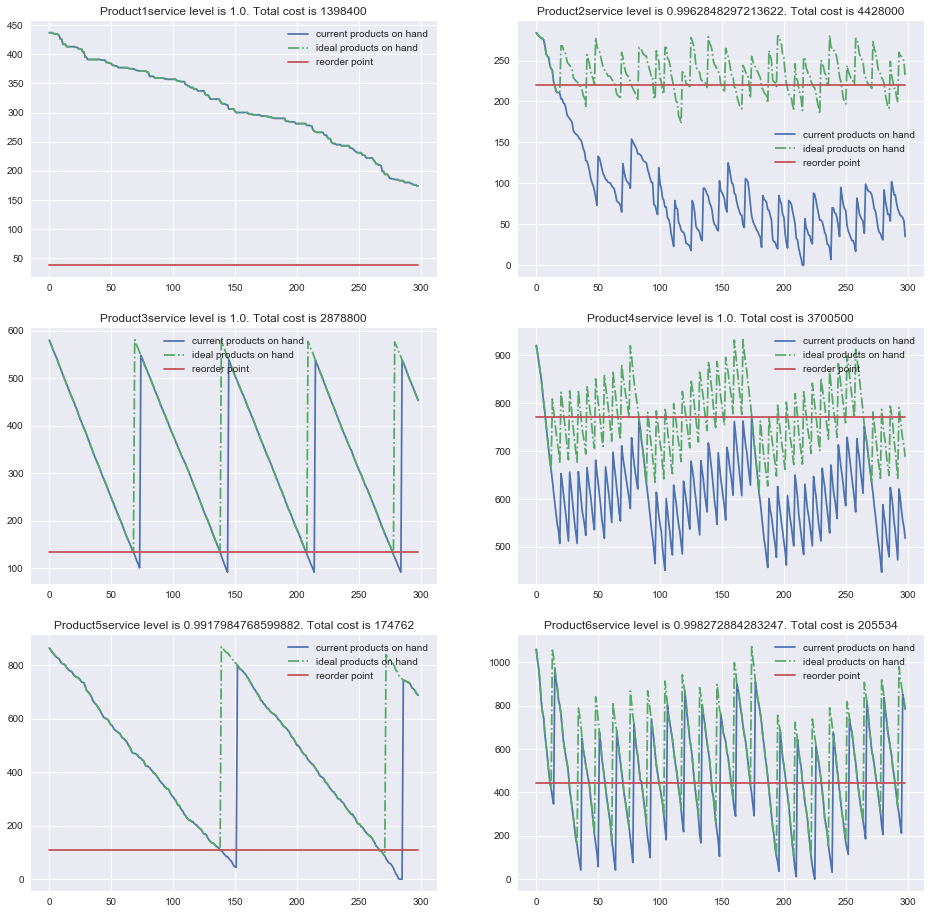

In [23]:
print_result(300, r1)

When penalty is large, the service level will larger than 0.8%. 

### A another solution: KKT (Karush–Kuhn–Tucker) 
https://en.wikipedia.org/wiki/Karush–Kuhn–Tucker_conditions

In [11]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern


from objective_function import objective_function_KKT

In [12]:
def obj(x):
    return objective_function_KKT(x, days = 300, plotdata = False, target_service_level = 0.8)
bounds = np.array([[20,800] for _ in range(6 * 2)] + [[1,1e10] for _ in range(6) ])

In [13]:
X_init, Y_init= initial_points(bounds, 12)

In [14]:
Y_init

array([-4.44389578e+09,  5.16892928e+08, -4.47015915e+09, -4.97372659e+09,
        4.81980575e+09, -5.18519507e+09,  9.62121076e+08, -4.19591088e+09,
        1.63670990e+09, -3.84838236e+09, -1.66950037e+09,  5.21925019e+09])

In [15]:
# Use custom kernel and estimator to match previous example
#m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
#gpr = GaussianProcessRegressor(kernel=m52, alpha=0.1**2)
m52 = ConstantKernel(1.0) * Matern(length_scale=np.array([1] * 18), nu=2.5)
gpr4 = GaussianProcessRegressor(kernel=m52, alpha=0.1**2)


r4 = gp_minimize(obj, 
                bounds.tolist(),
                base_estimator=gpr4,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=80,         # number of iterations
                n_random_starts=20,
                #,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=Y_init.ravel())

the minimize cost is, -8946762542.845865
the best parameter is [121.23841020726077, 744.9754674637705, 123.01024048217839, 642.9235295054108, 774.9551034421611, 406.44764114899107, 56.93094638434467, 202.31220956538738, 620.107614261394, 254.45488736825493, 402.2824225750998, 570.7495116358941, 9862661397.443752, 3438151452.692723, 9645320536.073797, 9418314262.547405, 3287080643.8123994, 9502952417.853634]
all cost is:  14133555.1407944


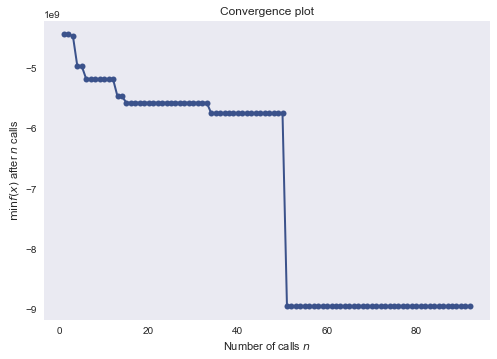

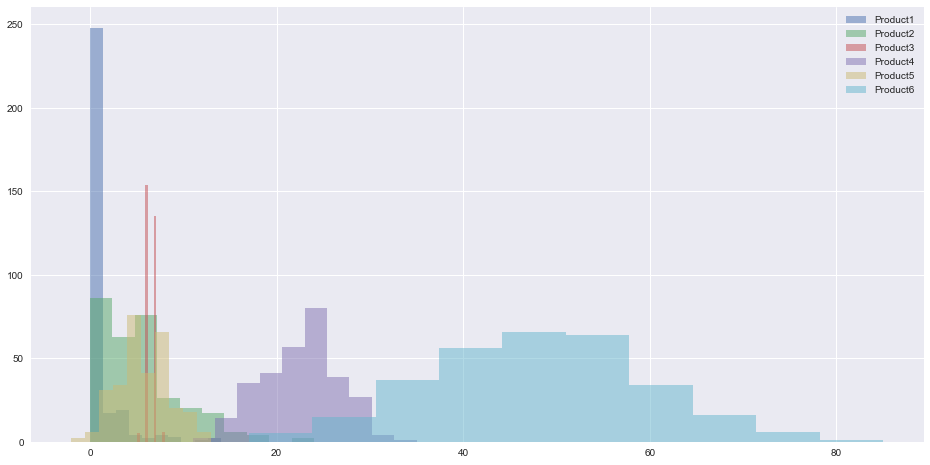

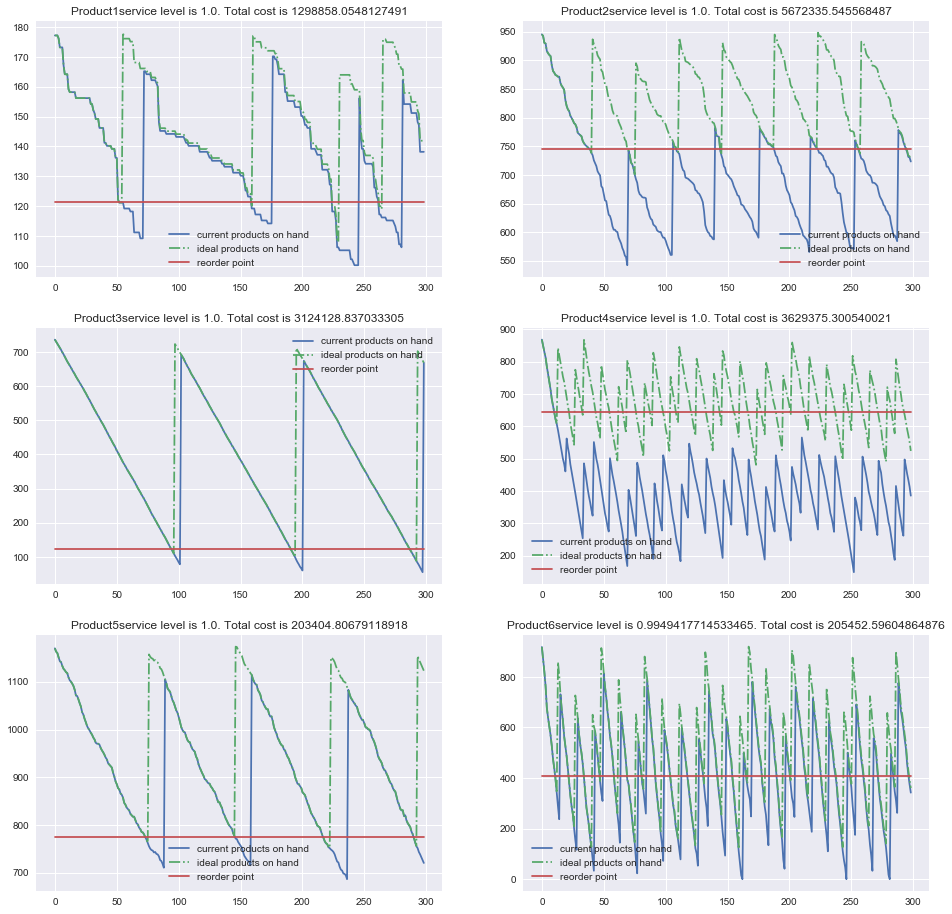

In [16]:
print_result(300, r4)